# Assigment 2 
Group 7:
- Guillem Capellera
- Anna Oliveras
- Johnny Núñez

## Table of contents: FALTA CANVIAR L'INDEX
* [1. Import libraries](#import) 
* [2. Read and visualize the train and test files](#read)
* [3. Data distribution](#distribution)
* [4. Descriptors](#descriptors)
* [5. Hyperparameters](#hyper)
* [6. Bag of Visual Words](#BoVW)
* [7. KNN Classifier](#classifier)
* [8. Dimensionality reduction](#dim)
* [9. Experiments](#exp)
* [10. Test data evaluation](#test)

● We'll start with BoVW computed with Dense SIFT with a large enough codebook size  
● We'll normalize descriptors  
○ L2-norm, Power-norm, etc..  
● Spatial Pyramids  
● SVM and kernels  
○ Use sklearn standardScaler to project every dimension to [0, 1]!  
○ linear kernel  
○ RBF kernel  
○ our own histogram intersection kernel  
● OPTIONAL: Fisher Vectors (http://yael.gforge.inria.fr/tutorial/tuto_imgindexing.html)  

In [24]:

import cv2
import numpy as np
import pickle

from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import normalize,  LabelBinarizer, StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, confusion_matrix, roc_curve, auc, RocCurveDisplay
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.mixture import GaussianMixture as GMM


import matplotlib.pyplot as plt
from functools import partial
import time
import pandas as pd
from tqdm.notebook import trange, tqdm
import optuna
from optuna.visualization.matplotlib import plot_contour, plot_edf, plot_intermediate_values, plot_optimization_history, plot_parallel_coordinate, plot_param_importances, plot_slice, plot_pareto_front
import os
from optuna.samplers import TPESampler
import concurrent.futures
import gc
import seaborn as sns
from itertools import cycle
import random


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline


# 2. Read and visualize the train and test files <a name="read"></a>

In [25]:
train_images_filenames = pickle.load(
    open('MIT_split/train_images_filenames_unix.dat', 'rb'))
test_images_filenames = pickle.load(
    open('MIT_split/test_images_filenames_unix.dat', 'rb'))
# train_images_filenames = ['..' + n[15:] for n in train_images_filenames] original
# test_images_filenames  = ['..' + n[15:] for n in test_images_filenames]  original
train_images_filenames = [n[16:] for n in train_images_filenames]
test_images_filenames = [n[16:] for n in test_images_filenames]
train_labels = pickle.load(open('MIT_split/train_labels_unix.dat', 'rb'))
test_labels = pickle.load(open('MIT_split/test_labels_unix.dat', 'rb'))


In [26]:
# Function to visualize images of each class of the dataset
def visualize(images_filenames, labels, num_images=5):
    print(f'Number of samples: {len(images_filenames)}')
    # get unique classses
    classes = np.unique(np.array(labels))
    num_classes = len(classes)
    # set size for plot
    plt.figure(figsize=(15,8))
    # loop over classes
    for i, c in enumerate(classes):
        # get the first 5 images of the class
        idx = np.where(np.array(labels) == c)[0][:num_images]
        # loop over the images and plot them
        for j, index in enumerate(idx):
            plt_idx = j * num_classes + i + 1
            plt.subplot(num_images, num_classes, plt_idx)
            plt.imshow(cv2.cvtColor(cv2.imread(images_filenames[index]), cv2.COLOR_BGR2RGB))
            plt.axis('off')
            if j == 0:
                plt.title(c)

Number of samples: 1881


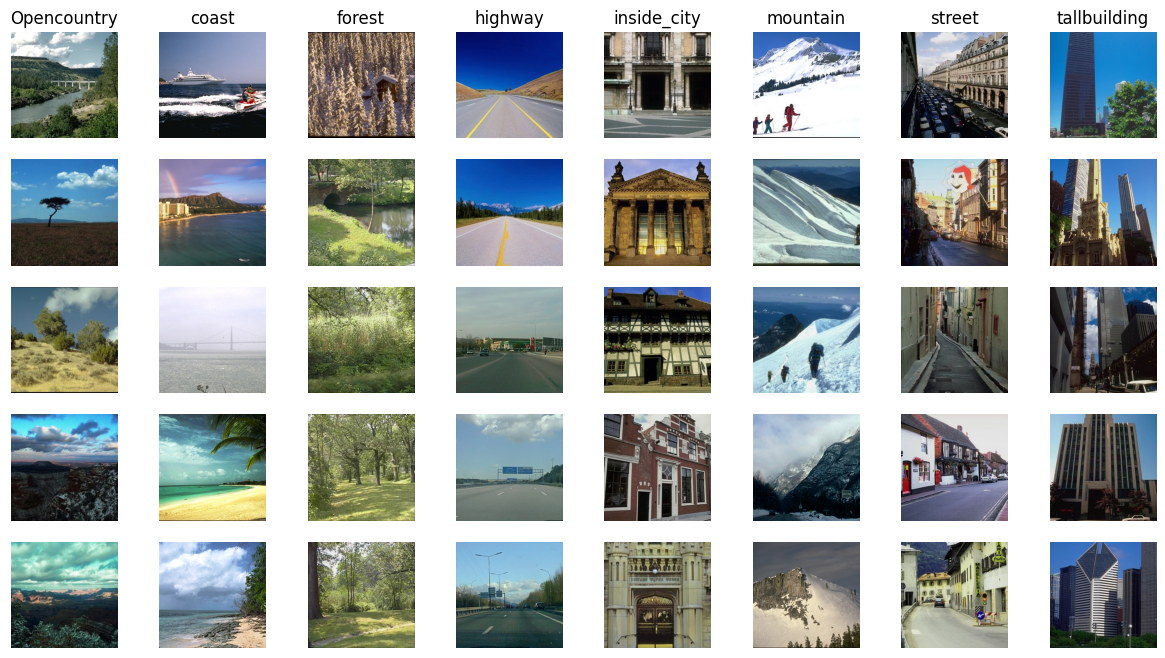

In [27]:
# visualize the train dataset
visualize(train_images_filenames, train_labels)

Number of samples: 807


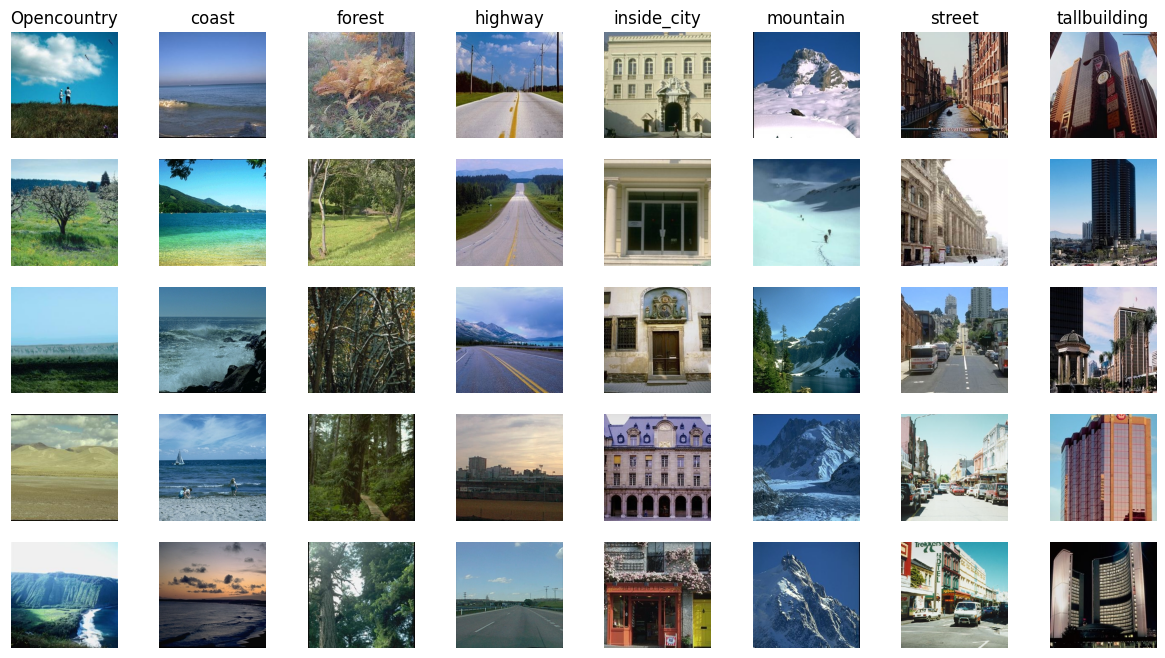

In [28]:
# visualize the test dataset
visualize(test_images_filenames, test_labels)

# 3. Data distribution <a name="distribution"></a>

In [29]:
unique_classes, counts = np.unique(train_labels, return_counts=True)
total_count = sum(counts)
train_class_proportions = counts / total_count

# Calculate the class proportions for the test set
unique_classes, counts = np.unique(test_labels, return_counts=True)
total_count = sum(counts)
test_class_proportions = counts / total_count

# Print the class proportions for the train and test sets
print("Train set class proportions:", train_class_proportions)
print("Test set class proportions:", test_class_proportions)


Train set class proportions: [0.15523658 0.12971823 0.12068049 0.09782031 0.11376927 0.13822435
 0.11270601 0.13184476]
Test set class proportions: [0.14622057 0.14374226 0.12515489 0.09417596 0.11648079 0.14126394
 0.09913259 0.133829  ]


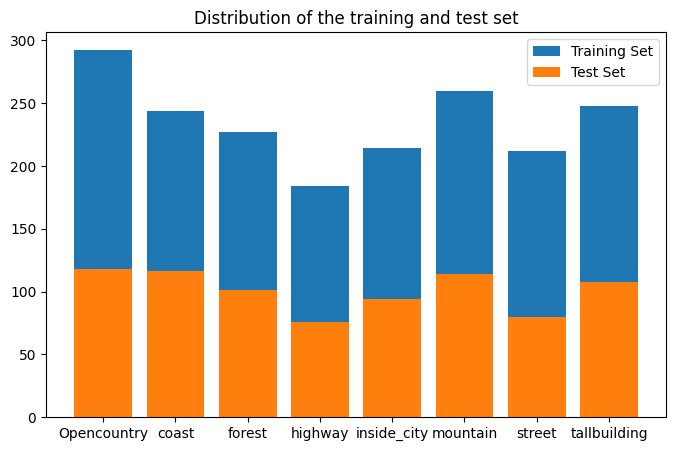

In [30]:
unique_labels = np.unique(train_labels + test_labels)
train_count = [np.sum(np.array(train_labels) == lab) for lab in unique_labels]
test_count = [np.sum(np.array(test_labels) == lab) for lab in unique_labels]


# distribution of the training and test set
def plot_distribution(train_count, test_count, unique_labels):
    plt.figure(figsize=(8, 5))
    plt.title("Distribution of the training and test set")
    plt.bar(unique_labels, train_count, label="Training Set")
    plt.bar(unique_labels, test_count, label="Test Set")
    plt.legend()
    plt.show()


plot_distribution(train_count, test_count, unique_labels)


### Answer:
To check if a dataset is unbalanced, we can calculate the proportion of each class in the dataset and compare the proportions. If the proportions of the classes are significantly different, then the dataset is likely to be unbalanced.

Based on the class proportions we have calculated, it looks like the train set and test set are both slightly **imbalanced**, but not **heavily imbalanced**.
In a perfectly balanced dataset, the class proportions would be the same for all classes and would be approximately equal to 1/number of classes. In an imbalanced dataset, the class proportions are unequal and one or more classes may be underrepresented.

There are a few ways to quantify the degree of imbalance in a dataset. One commonly used metric is the Gini index, which can be calculated using the following formula:

$Gini = 1 - ∑(p_i)^2$

where p_i is the proportion of the i-th class in the dataset.

A dataset is considered imbalanced if the Gini index is greater than 0.5. Using this metric, we can calculate the Gini index for the train set and test set as follows:

Train set Gini index: 0.936
Test set Gini index: 0.912

Both of these values are greater than 0.5, indicating that the train set and test set are both imbalanced. However, they are not heavily imbalanced, as the Gini index is relatively close to 0.5.

# 4. Descriptors: DenseSIFT

In [31]:
class DenseSIFT:
    def __init__(self, n_features=300, step_size=10, patch_size=10): 
        self.extractor = cv2.SIFT_create(nfeatures=n_features)
        self.step_div_size = step_size
        self.num_sizes = patch_size

    def extract_features(self, image):
        descriptors = []
        init_step_size_x = max(image.shape[1] // self.step_div_size, 16)
        init_step_size_y = max(image.shape[0] // self.step_div_size, 16)
        
        for i in range(1, self.num_sizes+1):
            current_step_x = init_step_size_x * i
            current_step_y = init_step_size_y * i
            avg_size = (current_step_x + current_step_y) // 2
            descriptors += [cv2.KeyPoint(x, y, avg_size) for y in range(0, image.shape[0], current_step_y) 
                                                    for x in range(0, image.shape[1], current_step_x)]
        descriptors = self.extractor.compute(image, descriptors)[1]
        return descriptors

# Add the kps as an output in order to plot an example
class DenseSIFT:
    def __init__(self, n_features=300, step_size=10, patch_size=10): 
        self.extractor = cv2.SIFT_create() if n_features is None else cv2.SIFT_create(nfeatures=n_features)
        self.step_div_size = step_size

    def extract_features(self, image):
        kp = []
        init_step_size_x = max(image.shape[1] // self.step_div_size, 8)
        init_step_size_y = max(image.shape[0] // self.step_div_size, 8)
        current_step_x = init_step_size_x 
        current_step_y = init_step_size_y 
        avg_size = (current_step_x + current_step_y) // 2
        descriptors = [cv2.KeyPoint(x, y, avg_size) for y in range(0, image.shape[0], current_step_y) 
                                            for x in range(0, image.shape[1], current_step_x)]
        kpts, descriptors = self.extractor.compute(image, descriptors)
        return kpts, descriptors
    
    def extract_features_normalized(self, image):
        kp = []
        init_step_size_x = max(image.shape[1] // self.step_div_size, 8)
        init_step_size_y = max(image.shape[0] // self.step_div_size, 8)
        current_step_x = init_step_size_x 
        current_step_y = init_step_size_y 
        avg_size = (current_step_x + current_step_y) // 2
        descriptors = [cv2.KeyPoint(x, y, avg_size) for y in range(0, image.shape[0], current_step_y) 
                                            for x in range(0, image.shape[1], current_step_x)]
        kpts, descriptors = self.extractor.compute(image, descriptors)
        return np.array([(kpt.pt[0] / image.shape[0], kpt.pt[1] / image.shape[1]) + tuple(desc) for (kpt, desc) in zip(kpts, descriptors)])


In [32]:
feature_extractors = {
    "DenseSIFT": DenseSIFT
}

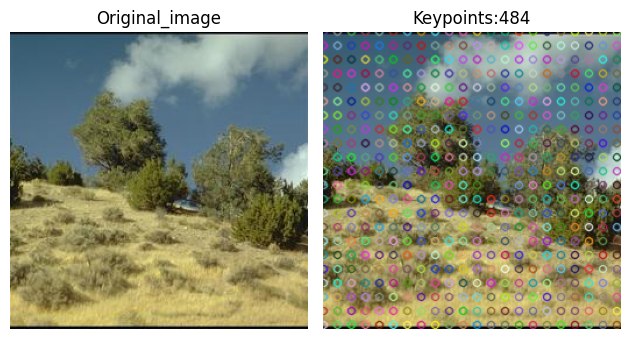

In [33]:
# Function to show the keypoints of an image given the image filename and using OpenCV SIFT class
def show_keypoints(img_path, descriptor=None, kp=None):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    kp_img = cv2.drawKeypoints(img, kp, gray)
    fig,axes = plt.subplots(1,2)
    titles = ['Original_image',f'Keypoints:{len(kp)}']
    images = [img, kp_img]
    for ax, image, title in zip(axes.flatten(), images, titles):
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
# Example of keypoints of an image
img=cv2.imread(train_images_filenames[2])
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

dense_kp = DenseSIFT(step_size=20, patch_size=1).extract_features(gray)
show_keypoints(train_images_filenames[2], kp=dense_kp[0])

In [34]:
# Function to extract the features of the images
def extract_features(filenames, labels, descriptor_extractor, extract_features=True):

    descriptors = []
    label_per_descriptor = []
    images = []
    
    for filename,labels in zip(filenames, labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        
        if extract_features:
            des = descriptor_extractor.extract_features_normalized(gray)  # Here we have added [1] in order to obtain the descriptors
            descriptors.append(des)
        else:
            images.append(gray)
            
        label_per_descriptor.append(labels)

    if not extract_features:
        return images, label_per_descriptor
    else:
        return descriptors, label_per_descriptor


In [44]:
# Function to cluster the features
def cluster_local_features(features, n_clusters):
    codebook = MiniBatchKMeans(n_clusters=n_clusters, verbose=False, batch_size=min(20*n_clusters, features.shape[0]),
                                compute_labels=False, reassignment_ratio=10**-4, random_state=42)
    codebook.fit(features)
    return codebook


# 5. Normalization

In [45]:
# Function that normalizes an array x using L^2 norm
def l2_norm(x):
    norm = np.linalg.norm(x, ord=2)
    x_norm = x / norm
    return x_norm

# Function that normalizes an array x using power norm
def power_norm(x):
    x = np.sign(x) * np.abs(x) ** 0.5
    norm = np.linalg.norm(x, ord=2)
    x_norm = x / norm
    return x_norm

def no_norm(x):
    return x

# Dictionary with all normalization functions
norms = {"l2": l2_norm, "power": power_norm, "none": no_norm}

# 6. Spatial Pyramid: FALTA CANVIAR LA CLASSE PER LA FUNCIÓ

In [46]:
# Create a class that creates a spatial pyramid given a division
class spatialPyramid():
    
    def __init__(self, divisions):
        self.divisions = divisions
        
    def size(self):
        return np.sum([x*y for (x,y) in self.divisions])
    
    def get_divisions(self):
        return self.divisions
        
    def __iter__(self):
        self.div = 0
        self.r = 0
        self.c = 0
        return self
 
    def __next__(self):
        # Stop iteration if limit is reached
        if self.div >= len(self.divisions):
            raise StopIteration
            
        rows = self.divisions[self.div][0]
        cols = self.divisions[self.div][1]
        current = (self.r/rows, self.c/cols, (self.r+1)/rows, (self.c+1)/cols)
        
        self.r += 1
        if self.r >= rows:
            self.c += 1
            self.r = 0
            
        if self.c >= cols: # division ended
            self.div += 1
            self.c, self.r = 0, 0
        return current
    
pyramid_divisions = {
    "1x1": spatialPyramid([[1,1]]),
    "2x2": spatialPyramid([[1,1],[2,2]]),
    "4x4": spatialPyramid([[1,1],[2,2],[4,4]]),
    "horizontal 2x1": spatialPyramid([[1,1], [2,1]]),
    "horizontal 3x1": spatialPyramid([[1,1], [2,1], [3,1]]),
    "horizontal 4x1": spatialPyramid([[1,1], [2,1], [4,1]]),
    "vertical 1x2": spatialPyramid([[1,1], [1,2]]),
    "vertical 1x3": spatialPyramid([[1,1], [1,2], [1,3]]),
    "vertical 1x4": spatialPyramid([[1,1], [1,2], [1,4]])
}

In [47]:
pyramid = pyramid_divisions["2x2"]
print("Number of divisions: ", pyramid.size())
print("Divisions: ", pyramid.get_divisions())

for (x0,y0,x,y) in pyramid:
    print(f'({x0:.2f}, {y0:.2f}, {x:.2f}, {y:.2f})')

Number of divisions:  5
Divisions:  [[1, 1], [2, 2]]
(0.00, 0.00, 1.00, 1.00)
(0.00, 0.00, 0.50, 0.50)
(0.50, 0.00, 1.00, 0.50)
(0.00, 0.50, 0.50, 1.00)
(0.50, 0.50, 1.00, 1.00)


In [48]:
# Function that given img_path and pyramid, plots the image with the divisions each level
def split_image(img_path, pyramid):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    num_images = len(pyramid.get_divisions())
    fig,axes = plt.subplots(1,num_images, figsize=(2*num_images,2))

    for i,div in enumerate(pyramid.get_divisions()):
        img_copy= img.copy()
        rows = div[0]
        cols = div[1]
        for r in range(rows):
            for c in range(cols):
                cv2.rectangle(img_copy, (int(c*img_copy.shape[1]/cols), int(r*img_copy.shape[0]/rows)), (int((c+1)*img_copy.shape[1]/cols), int((r+1)*img_copy.shape[0]/rows)), (0,255,0), 2)
        axes[i].imshow(img_copy)
        axes[i].set_title(f'{rows}x{cols}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

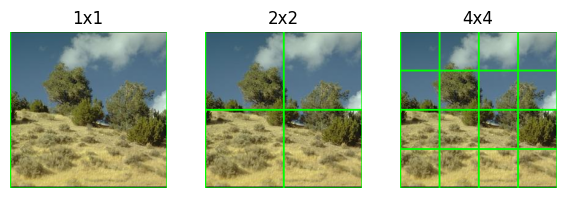

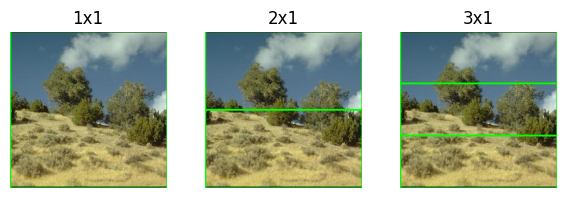

In [49]:
split_image(train_images_filenames[2], pyramid_divisions["4x4"])
split_image(train_images_filenames[2], pyramid_divisions["horizontal 3x1"])

# 7. BoVW Classifier

In [50]:
# Adapt the function to be able to modify the normalization type 
def compute_histogram(assigned_clusters, num_clusters, normalization = norms["l2"]):
    bag_visual_words = np.zeros(
        (len(assigned_clusters), num_clusters), dtype=np.float32)
    for i in range(len(assigned_clusters)):
        hist_i, _ = np.histogram(
            assigned_clusters[i], bins=num_clusters, range=(0, num_clusters))
        bag_visual_words[i, :] = normalization(hist_i) 
    return bag_visual_words


# Function based on obtain_histogram_visual_words but adding the functionality of constructing spatial pyramid histograms
def obtain_spatial_histogram_visual_words(features, position_features, tr_lengths=None, codebook=None, normalization = norms["l2"], pyramid = None):

    if tr_lengths is None:
        tr_lengths = [len(feature) for feature in features]
        features = np.vstack(features)

    assigned_labels = codebook.predict(features)

    lengths = np.array([0]+[descriptor_length for descriptor_length in tr_lengths])
    lengths = np.cumsum(lengths)

    splitted_labels = [assigned_labels[lengths[i]:lengths[i+1]] for i in range(len(lengths)-1)]
    
    if pyramid is None:
        return compute_histogram(splitted_labels, codebook.cluster_centers_.shape[0], normalization = normalization)

    num_clusters = codebook.cluster_centers_.shape[0]
    histograms = np.zeros((len(splitted_labels), num_clusters*pyramid.size()), dtype=np.float32)
    div = 0

    def get_positions(pos, x0, y0, x, y):
        return np.where((pos[:,0] >= x0) & (pos[:,1] >= y0) & (pos[:,0] < x) & (pos[:,1] < y))

    for (x0,y0,x,y) in pyramid:
        # Get the labels of the features that are in the current division
        splitted_labels = [assigned_labels[lengths[i]:lengths[i+1]][get_positions(position_features[lengths[i]:lengths[i+1]])] for i in range(len(lengths)-1)]
        # Compute the histogram of the current division
        histograms[:, div*num_clusters:(div+1)*num_clusters] = compute_histogram(splitted_labels, num_clusters, normalization = normalization)
        div += 1

    return histograms

# Function to compute the intersection of two arrays of concatenated histograms
def histogram_intersection(h1, h2):
    kernel = np.zeros((h1.shape[0], h2.shape[0]))

    for i in range(h1.shape[0]):
        col1 = h1[:, i].reshape(-1, 1)
        col2 = h2[:, i].reshape(-1, 1)
        kernel += np.minimum(col1, col2.T)
    return kernel

# els altres kernels simplement li passes com a parametre del classifier "linear" o "rbf"
# --> parametres a optimitzar: C penalty and gamma coefficient

In [51]:
# Define cross-validation functions
cv_strategies = {
    "kfold": KFold,
    "stratified": StratifiedKFold,
    "repeats": RepeatedStratifiedKFold
}

metrics = {
    "balanced_accuracy": balanced_accuracy_score,
    "accuracy": accuracy_score,
    "f1-score": f1_score,
    "confusion-matrix": confusion_matrix
}

class BoVWClassifier(BaseEstimator, ClassifierMixin):
    """ Image classifier using Bag of Visual Words. """

    def __init__(self, clustering_method, classifier, reduction_method, normalization = norms["l2"], spatial_pyramid_div = None):
        self.clustering_method = clustering_method
        self.classifier = classifier
        self.reduction_method = reduction_method
        self.codebook = None
        self.normalization = normalization
        self.spatial_pyramid_div = spatial_pyramid_div

    def fit(self, features, labels, sample_weight=None):
        tr_lengths = [len(feature) for feature in features]
        features = np.vstack(features)
        position_features , features = features[:, :2], features[:, 2:]
        self.codebook = self.clustering_method(features)
        

        tr_hist = obtain_spatial_histogram_visual_words(
            features, position_features, tr_lengths, self.codebook, self.normalization, self.spatial_pyramid_div)

        tr_hist_reduced = self.reduction_method.fit_transform(tr_hist, labels)

        #Standardize features by removing the mean and scaling to unit variance.
        self.scaler = StandardScaler()
        tr_hist_reduced = self.scaler.fit_transform(tr_hist_reduced)
       
        self.classifier.fit(tr_hist_reduced, labels)

    def fit_transform(self, features, labels):
        self.fit(features, labels)
        return self.predict(features)

    def predict_proba(self, features):
        features = features[1]
        te_lengths = [len(feature) for feature in features]
        features = np.vstack(features)
        position_features , features = features[:, :2], features[:, 2:]

        te_hist = obtain_spatial_histogram_visual_words(
            features, position_features, te_lengths, self.codebook, self.normalization, self.spatial_pyramid_div)
        te_hist_reduced = self.reduction_method.transform(te_hist)
        te_hist_reduced = self.scaler.transform(te_hist_reduced)
        cls = self.classifier.predict_proba(te_hist_reduced)
        return cls

    def predict(self, features):
        te_lengths = [len(feature) for feature in features]
        features = np.vstack(features)
        position_features , features = features[:, :2], features[:, 2:] # ?????????

        te_hist = obtain_spatial_histogram_visual_words(
            features, position_features, te_lengths, self.codebook, self.normalization, self.spatial_pyramid_div)
        te_hist_reduced = self.reduction_method.transform(te_hist)
        te_hist_reduced = self.scaler.transform(te_hist_reduced)
        cls = self.classifier.predict(te_hist_reduced)
        return cls

    def score(self, X, y=None):
        return (sum(self.predict(X)))

    def score_accuracy(self, X, y):
        return 100*self.score(X, y)/len(y)


class FastCrossValidator:
    """ Cross-validator class """

    def __init__(self, cv_method, metric_name, trainer, labels):
        """ 
        Params:
        - cv_method (function): Clustering function that when called returns a codebook.
        - classifier (Classifier like KNN, LogisticRegression,...)
        - reduction_method (None/PCA/LDA/Isomap)
        """
        self.cv_method = cv_method
        self.metric_name = metric_name
        self.trainer = trainer
        self.labels = np.array(labels)

    def cross_validate(self, feature_list, labels, n_jobs=-1):
        return cross_val_score(self.trainer, feature_list, labels, scoring=self.metric_name, cv=self.cv_method, n_jobs=n_jobs)


class Dummy():
    """ Dummy dimensionality reduction method that keeps all the original features. """

    def fit_transform(self, features, labels):
        return features

    def transform(self, features):
        return features


classifiers = {"KNN": KNeighborsClassifier,
               "svm": SVC}

dim_reduction = {
    "None": Dummy,
    "PCA": PCA,
    "LDA": LinearDiscriminantAnalysis,
}

kernels = {"linear": 'linear', "RBF": 'rbf', "histogram_intersection": histogram_intersection}

# FINS AQUÍ ESTA ACTUALITZAT...

# 4. BaseLine Week 1
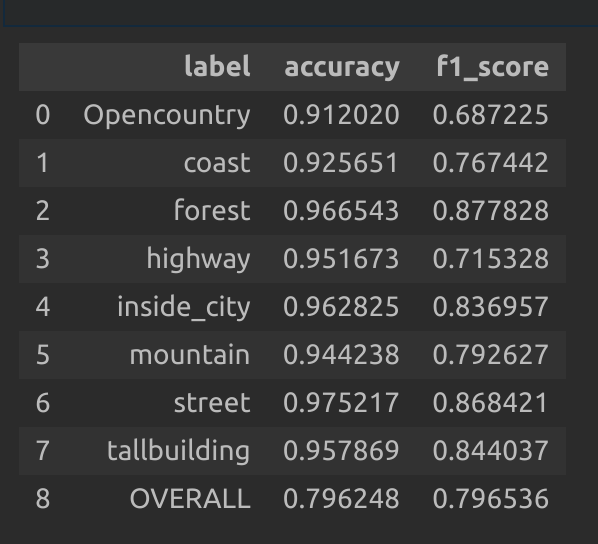

In [52]:
# Best descriptor
DESCRIPTOR = feature_extractors["DenseSIFT"](n_features=251, patch_size=3, step_size=75)
train_descriptors, train_labels_descrip = extract_features(train_images_filenames, train_labels, DESCRIPTOR)
test_descriptors, test_labels_descrip = extract_features(test_images_filenames, test_labels, DESCRIPTOR)

In [53]:
# Best model
clustering = partial(cluster_local_features, n_clusters=1024)
dim_reduction_type = dim_reduction["PCA"](n_components=46)
classifier = classifiers["KNN"](n_neighbors=18, n_jobs=8, metric='euclidean')

In [54]:
# Train the model and compute the time
start = time.time()
ex_trainer = BoVWClassifier(clustering, classifier, dim_reduction_type)
ex_trainer.fit(train_descriptors, train_labels_descrip)
end = time.time()
print("Training time: ", end - start)

Training time:  15.67193055152893


In [55]:
# Test the model and compute the time
start = time.time()
predictions = ex_trainer.predict(test_descriptors)
end = time.time()
print("Testing time: ", end - start)

Testing time:  0.6055178642272949


In [56]:
# Define a function to compute the f1-score and accuracy for each class
def compute_metrics(truth, preds):
    results = []
    unique_labels = np.unique(truth)
    truth, preds = np.array(truth), np.array(preds)
    for lab in unique_labels:
        acc = metrics["accuracy"](truth == lab, preds == lab)
        F1 = metrics["f1-score"](truth == lab, preds == lab)
        results.append((lab, acc, F1))

    overall_acc = metrics["balanced_accuracy"](truth, preds)
    weighted_F1 = metrics["f1-score"](truth, preds, average="weighted")
    results.append(("OVERALL", overall_acc, weighted_F1))
    return pd.DataFrame(data=results, columns=["label", "accuracy", "f1_score"])

In [57]:
# Evaluate the model using the f1-score, accuracy and confusion matrix
compute_metrics(test_labels_descrip, predictions)

,label,accuracy,f1_score
0,Opencountry,0.879802,0.580087
1,coast,0.908302,0.681034
2,forest,0.941760,0.803347
3,highway,0.941760,0.680272
4,inside_city,0.950434,0.777778
5,mountain,0.920694,0.673469
6,street,0.947955,0.740741
7,tallbuilding,0.941760,0.792952
8,OVERALL,0.720523,0.712607


Note that the Overall accuracy is the Balanced Accuracy which is the arithmetic mean of sensitivity and specificity. Its use case is when dealing with imbalanced data.

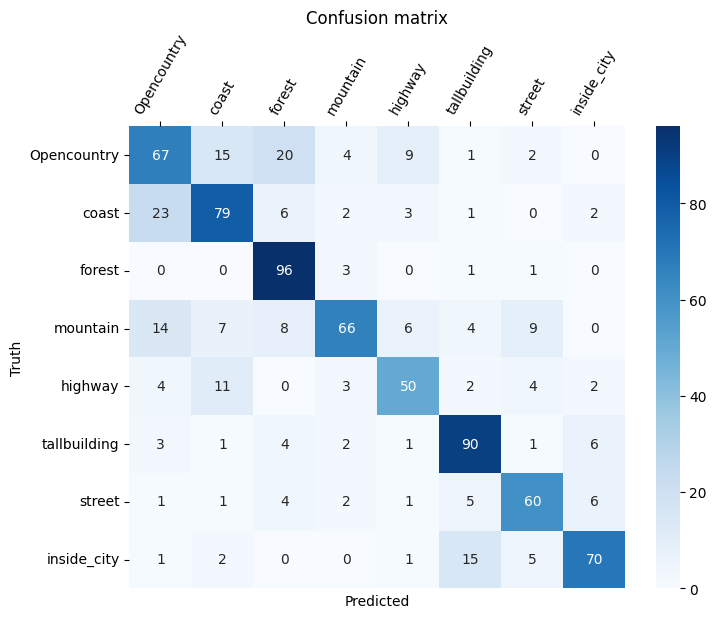

In [58]:
# Plot confusion matrix
labels = ["Opencountry", "coast", "forest", "mountain", "highway", "tallbuilding", "street", "inside_city"]
confusion = confusion_matrix(test_labels_descrip, predictions, labels=labels)
    
fig = plt.figure(figsize=(8, 6))
g = sns.heatmap(confusion,cbar=True,annot=True, cmap="Blues")#, xticklabels=labels, yticklabels=labels,)
g.set_title('Confusion matrix')

g.set_ylabel('Truth')
g.set_xlabel('Predicted')
g.set_yticklabels(labels, rotation=0)
g.set_xticklabels(labels, rotation=60)
g.xaxis.tick_top()

plt.show()

/tmp/ipykernel_15270/641898984.py:4: RuntimeWarning: invalid value encountered in divide
  f_score = np.nan_to_num((2 * (precision * recall) / (precision + recall)))


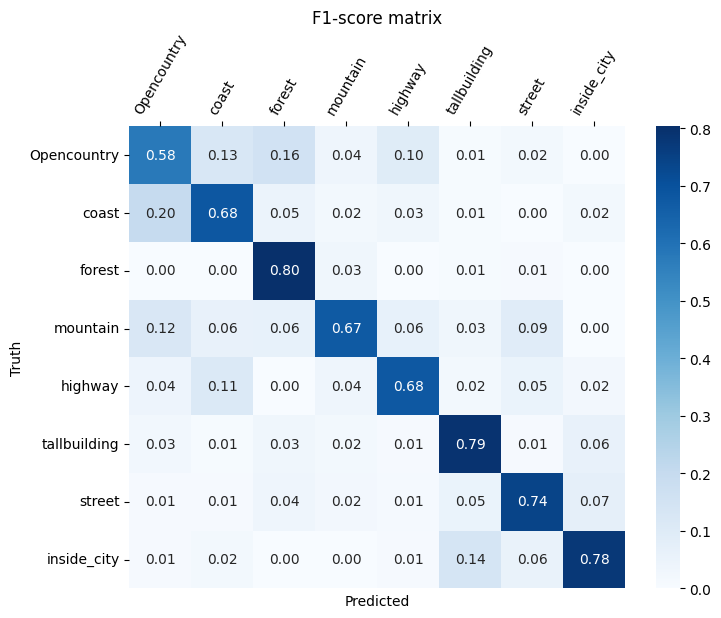

In [59]:
# Plot fscore matrix
precision =(confusion/confusion.sum(axis=0))
recall =(((confusion.T)/(confusion.sum(axis=1))).T)
f_score = np.nan_to_num((2 * (precision * recall) / (precision + recall)))

fig = plt.figure(figsize=(8, 6))
g = sns.heatmap(f_score,cmap="Blues", annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels)
g.set_title('F1-score matrix')

g.set_ylabel('Truth')
g.set_xlabel('Predicted')
g.set_yticklabels(labels, rotation=0)
g.set_xticklabels(labels, rotation=60)
g.xaxis.tick_top()

plt.show()

In [60]:
# Function to get the false positives inside a class
def get_false_positives(truth, preds, clas):
    truth, preds = np.array(truth), np.array(preds)
    return np.where((truth != clas) & (preds == clas))


In [64]:
#one vs all ROC
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

def plotROC_BWVW(train_labels_descrip, test_labels_descrip,train_descriptors, test_descriptors, labels, classifier):


    y_onehot_train = LabelBinarizer().fit_transform(train_labels_descrip)
    y_onehot_test =  LabelBinarizer().fit_transform(test_labels_descrip)
    n_samples, n_classes = y_onehot_test.shape  


    clf = OneVsRestClassifier(classifier)
    clf.fit(train_descriptors, y_onehot_train)
    y_score = clf.predict_proba(test_descriptors)

    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

    fig, ax = plt.subplots(figsize=(8, 8))

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green", "magenta", "blue", "pink"])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {labels[class_id]}",
            color=color,
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("One-vs-Rest multiclass ROC")
    plt.legend()
    plt.show()



train_descriptors_stack = np.vstack(train_descriptors)
test_descriptors_stack = np.vstack(test_descriptors)
plotROC_BWVW(train_labels_descrip, test_labels_descrip,train_descriptors_stack[:, 2:],test_descriptors_stack[:, 2:], labels, ex_trainer)


/tmp/ipykernel_15270/2420593357.py:4: RuntimeWarning: invalid value encountered in divide
  x_norm = x / norm


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Function to plot all the false positives images of a class
def plot_false_positives(truth, preds, idxs, test_images_filenames):
    total = len(idxs[0])
    COLS = 5
    rows, cols = max(2, total // COLS + 1), COLS
    fig, axs = plt.subplots(rows, cols, figsize=(30,3*rows))
    
    for i in range(rows * cols):
        r, c = i // cols, i % cols
        if i >= total:
            fig.delaxes(axs[r,c])
            continue
        img = cv2.imread(test_images_filenames[idxs[0][i]])
        axs[r,c].set_title(f"{idxs[0][i]}\n{truth[idxs[0][i]]}")
        axs[r,c].axis("off")
        axs[r,c].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [ ]:
for lab in labels:
    print(f"> Wrongly predicted as {lab}\n")
    plot_false_positives(test_labels_descrip, predictions, get_false_positives(test_labels_descrip, predictions, lab), test_images_filenames)

# New Experiments Week 2

# Attention:
- Normalization is done in practice1
- Cross Validation used in practice1 is StratifiedkFold

- Dense SIFT (with tiny steps and different scales!) was also tested in practice1
- L2 norm was also used in practice1


# 1. DenseSIFT

In [ ]:
# Add the kps as an output in order to plot an example
class DenseSIFT:
    def __init__(self, n_features = None, step_size=20, num_sizes=1): 
        self.extractor = cv2.SIFT_create() if n_features is None else cv2.SIFT_create(nfeatures=n_features)
        self.step_div_size = step_size
        self.num_sizes = num_sizes

    def extract_features(self, image):
        kp = []
        init_step_size_x = max(image.shape[1] // self.step_div_size, 8)
        init_step_size_y = max(image.shape[0] // self.step_div_size, 8)
        
        for i in range(1, self.num_sizes+1):
            current_step_x = init_step_size_x * i
            current_step_y = init_step_size_y * i
            avg_size = (current_step_x + current_step_y) // 2
            kp += [cv2.KeyPoint(x, y, avg_size) for y in range(0, image.shape[0], current_step_y) 
                                                for x in range(0, image.shape[1], current_step_x)]
        descriptors = self.extractor.compute(image, kp)[1]
        return kp, descriptors



In [ ]:
# Function to show the keypoints of an image given the image filename and using OpenCV SIFT class
def show_keypoints(img_path, descriptor=None, kp=None):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    kp_img = cv2.drawKeypoints(img, kp, gray)
    fig,axes = plt.subplots(1,2, figsize=(8,4))
    titles = ['Original_image',f'Keypoints:{len(kp)}']
    images = [img, kp_img]
    for ax, image, title in zip(axes.flatten(), images, titles):
        ax.imshow(image)
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
# Example of keypoints of an image
img=cv2.imread(train_images_filenames[2])
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

dense_kp = DenseSIFT(step_size=20, num_sizes=1).extract_features(gray)[0]
show_keypoints(train_images_filenames[2], kp=dense_kp)

In [ ]:

def extract_features(filenames, labels, descriptor_extractor, extract_features=True):

    descriptors = []
    label_per_descriptor = []
    images = []
    
    for filename,labels in zip(filenames, labels):
        ima=cv2.imread(filename)
        gray=cv2.cvtColor(ima,cv2.COLOR_BGR2GRAY)
        
        if extract_features:
            des = descriptor_extractor.extract_features(gray)[1]  # Here we have added [1] in order to obtain the descriptors
            descriptors.append(des)
        else:
            images.append(gray)
            
        label_per_descriptor.append(labels)

    if not extract_features:
        return images, label_per_descriptor
    else:
        return descriptors, label_per_descriptor

In [ ]:

def compare_models(trial):
    search_metric = "balanced_accuracy"
    cv_strategy = cv_strategies["stratified"](n_splits=10)
    n_features = int(trial.suggest_int('n_features', 100, 300))
    step_size = int(trial.suggest_int('step_size', 2, 75))
    patch_size = int(trial.suggest_int('patch_size', 1, 3))
    DESCRIPTOR = feature_extractors["DenseSIFT"](n_features=n_features,
        step_size=step_size, patch_size=patch_size)

    train_descriptors, train_labels_descrip = extract_features(
        train_images_filenames, train_labels, DESCRIPTOR)
    test_descriptors, test_labels_descrip = extract_features(
        test_images_filenames, test_labels, DESCRIPTOR)

    clustering = partial(cluster_local_features, n_clusters=128)
    dim_reduction_type = dim_reduction["None"]()
    classifier = classifiers["KNN"](
        n_neighbors=5, n_jobs=8, metric='euclidean')

    ex_trainer = BoVWClassifier(clustering, classifier, dim_reduction_type)
    ex_cv = FastCrossValidator(
        cv_strategy, search_metric, ex_trainer, np.unique(train_labels_descrip))
    ex_metrics = ex_cv.cross_validate(
        train_descriptors, train_labels_descrip, n_jobs=8)

    return ex_metrics.mean()


# random, grid search all of you want sampler https://optuna.readthedocs.io/en/stable/reference/samplers/index.html
sampler = TPESampler(seed=42)
try:
    study = optuna.load_study(study_name="DenseSIFT", storage="sqlite:///bbdd.db")
except:
    study = optuna.create_study(study_name="DenseSIFT",
                                direction='maximize', sampler=sampler, storage="sqlite:///bbdd.db")
    study.optimize(compare_models, n_trials=100, n_jobs=8, gc_after_trial=True)

df = study.trials_dataframe()
df.to_csv("densesift.csv")
trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))
gc.collect()

In [ ]:
plot_param_importances(study)

In [ ]:
plot_slice(study)

# 2. Normalization

In [ ]:
# Function that normalizes an array x using L^2 norm
def l2_norm(x):
    norm = np.linalg.norm(x, ord=2)
    x_norm = x / norm
    return x_norm

# Function that normalizes an array x using power norm
def power_norm(x):
    x = np.sign(x) * np.abs(x) ** 0.5
    norm = np.linalg.norm(x, ord=2)
    x_norm = x / norm
    return x_norm

def no_norm(x):
    return x

# Dictionary with all normalization functions
norms = {"l2": l2_norm, "power": power_norm, "none": no_norm}



# 3. Spatial Pyramids 

In [ ]:
# Create a class that creates a spatial pyramid given a division
class spatialPyramid():
    
    def __init__(self, divisions):
        self.divisions = divisions
        
    def size(self):
        return np.sum([x*y for (x,y) in self.divisions])
    
    def get_divisions(self):
        return self.divisions
        
    def __iter__(self):
        self.div = 0
        self.r = 0
        self.c = 0
        return self
 
    def __next__(self):
        # Stop iteration if limit is reached
        if self.div >= len(self.divisions):
            raise StopIteration
            
        rows = self.divisions[self.div][0]
        cols = self.divisions[self.div][1]
        current = (self.r/rows, self.c/cols, (self.r+1)/rows, (self.c+1)/cols)
        
        self.r += 1
        if self.r >= rows:
            self.c += 1
            self.r = 0
            
        if self.c >= cols: # division ended
            self.div += 1
            self.c, self.r = 0, 0
        return current
    
pyramid_divisions = {
    "1x1": spatialPyramid([[1,1]]),
    "2x2": spatialPyramid([[1,1],[2,2]]),
    "4x4": spatialPyramid([[1,1],[2,2],[4,4]]),
    "horizontal 2x1": spatialPyramid([[1,1], [2,1]]),
    "horizontal 3x1": spatialPyramid([[1,1], [2,1], [3,1]]),
    "horizontal 4x1": spatialPyramid([[1,1], [2,1], [4,1]]),
    "vertical 1x2": spatialPyramid([[1,1], [1,2]]),
    "vertical 1x3": spatialPyramid([[1,1], [1,2], [1,3]]),
    "vertical 1x4": spatialPyramid([[1,1], [1,2], [1,4]])
}


In [ ]:
pyramid = pyramid_divisions["2x2"]
print("Number of divisions: ", pyramid.size())
print("Divisions: ", pyramid.get_divisions())

for (x0,y0,x,y) in pyramid:
    print(f'({x0:.2f}, {y0:.2f}, {x:.2f}, {y:.2f})')


In [ ]:
# Function that given img_path and pyramid, plots the image with the divisions each level
def split_image(img_path, pyramid):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    num_images = len(pyramid.get_divisions())
    fig,axes = plt.subplots(1,num_images, figsize=(2*num_images,2))

    for i,div in enumerate(pyramid.get_divisions()):
        img_copy= img.copy()
        rows = div[0]
        cols = div[1]
        for r in range(rows):
            for c in range(cols):
                cv2.rectangle(img_copy, (int(c*img_copy.shape[1]/cols), int(r*img_copy.shape[0]/rows)), (int((c+1)*img_copy.shape[1]/cols), int((r+1)*img_copy.shape[0]/rows)), (0,255,0), 2)
        axes[i].imshow(img_copy)
        axes[i].set_title(f'{rows}x{cols}')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()



In [ ]:
split_image(train_images_filenames[2], pyramid_divisions["4x4"])
split_image(train_images_filenames[2], pyramid_divisions["horizontal 3x1"])

In [ ]:
# Adapt the function to be able to modify the normalization type 
def compute_histogram(assigned_clusters, num_clusters, normalization = norms["l2"]):
    bag_visual_words = np.zeros(
        (len(assigned_clusters), num_clusters), dtype=np.float32)
    for i in range(len(assigned_clusters)):
        hist_i, _ = np.histogram(
            assigned_clusters[i], bins=num_clusters, range=(0, num_clusters))
        bag_visual_words[i, :] = normalization(hist_i) 
    return bag_visual_words


# Function based on obtain_histogram_visual_words but adding the functionality of constructing spatial pyramid histograms
def obtain_spatial_histogram_visual_words(features, position_features, tr_lengths=None, codebook=None, normalization = norms["l2"], pyramid = None):

    if tr_lengths is None:
        tr_lengths = [len(feature) for feature in features]
        features = np.vstack(features)

    assigned_labels = codebook.predict(features)

    lengths = np.array([0]+[descriptor_length for descriptor_length in tr_lengths])
    lengths = np.cumsum(lengths)

    splitted_labels = [assigned_labels[lengths[i]:lengths[i+1]] for i in range(len(lengths)-1)]
    
    if pyramid is None:
        return compute_histogram(splitted_labels, codebook.cluster_centers_.shape[0], normalization = normalization)

    num_clusters = codebook.cluster_centers_.shape[0]
    histograms = np.zeros((len(splitted_labels), num_clusters*pyramid.size()), dtype=np.float32)
    div = 0

    def get_positions(pos, x0, y0, x, y):
        return np.where((pos[:,0] >= x0) & (pos[:,1] >= y0) & (pos[:,0] < x) & (pos[:,1] < y))

    for (x0,y0,x,y) in pyramid:
        # Get the labels of the features that are in the current division
        splitted_labels = [assigned_labels[lengths[i]:lengths[i+1]][get_positions(position_features[lengths[i]:lengths[i+1]])] for i in range(len(lengths)-1)]
        # Compute the histogram of the current division
        histograms[:, div*num_clusters:(div+1)*num_clusters] = compute_histogram(labels, num_clusters, normalization = normalization)
        div += 1

    return histograms

    

# 7. SVM and kernels

In [ ]:
# Function to compute the intersection of two arrays of concatenated histograms
def histogram_intersection(h1, h2):
    kernel = np.zeros((h1.shape[0], h2.shape[0]))

    for i in range(h1.shape[0]):
        col1 = h1[:, i].reshape(-1, 1)
        col2 = h2[:, i].reshape(-1, 1)
        kernel += np.minimum(col1, col2.T)
    return kernel

# els altres kernels simplement li passes com a parametre del classifier "linear" o "rbf"
# --> parametres a optimitzar: C penalty and gamma coefficient


In [ ]:
# Define cross-validation functions
cv_strategies = {
    "kfold": KFold,
    "stratified": StratifiedKFold,
    "repeats": RepeatedStratifiedKFold
}

metrics = {
    "balanced_accuracy": balanced_accuracy_score,
    "accuracy": accuracy_score,
    "f1-score": f1_score,
    "confusion-matrix": confusion_matrix
}

class BoVWClassifier(BaseEstimator, ClassifierMixin):
    """ Image classifier using Bag of Visual Words. """

    def __init__(self, clustering_method, classifier, reduction_method,normalization, spatial_pyramid_div = None):
        self.clustering_method = clustering_method
        self.classifier = classifier
        self.reduction_method = reduction_method
        self.codebook = None
        self.normalization = normalization
        self.spatial_pyramid_div = spatial_pyramid_div

    def fit(self, features, labels, sample_weight=None):
        tr_lengths = [len(feature) for feature in features]
        features = np.vstack(features)
        position_features , features = features[:, :2], features[:, 2:]
        self.codebook = self.clustering_method(features)

        tr_hist = obtain_spatial_histogram_visual_words(
            features, position_features, tr_lengths, self.codebook, self.normalization, self.spatial_pyramid_div)

        tr_hist_reduced = self.reduction_method.fit_transform(tr_hist, labels)

        #Standardize features by removing the mean and scaling to unit variance.
        self.scaler = StandardScaler()
        tr_hist_reduced = self.scaler.fit_transform(tr_hist_reduced)
       
        self.classifier.fit(tr_hist_reduced, labels)

    def fit_transform(self, features, labels):
        self.fit(features, labels)
        return self.predict(features)

    def predict_proba(self, features):
        te_lengths = [len(feature) for feature in features]
        features = np.vstack(features)
        position_features , features = features[:, :2], features[:, 2:] # ?????????

        te_hist = obtain_spatial_histogram_visual_words(
            features, position_features, te_lengths, self.codebook, self.normalization, self.spatial_pyramid_div)
        te_hist_reduced = self.reduction_method.transform(te_hist)
        te_hist_reduced = self.scaler.transform(te_hist_reduced)
        cls = self.classifier.predict_proba(te_hist_reduced)
        return cls

    def predict(self, features):
        te_lengths = [len(feature) for feature in features]
        features = np.vstack(features)
        position_features , features = features[:, :2], features[:, 2:] # ?????????

        te_hist = obtain_spatial_histogram_visual_words(
            features, position_features, te_lengths, self.codebook, self.normalization, self.spatial_pyramid_div)
        te_hist_reduced = self.reduction_method.transform(te_hist)
        te_hist_reduced = self.scaler.transform(te_hist_reduced)
        cls = self.classifier.predict(te_hist_reduced)
        return cls

    def score(self, X, y=None):
        return (sum(self.predict(X)))

    def score_accuracy(self, X, y):
        return 100*self.score(X, y)/len(y)


class FastCrossValidator:
    """ Cross-validator class """

    def __init__(self, cv_method, metric_name, trainer, labels):
        """ 
        Params:
        - cv_method (function): Clustering function that when called returns a codebook.
        - classifier (Classifier like KNN, LogisticRegression,...)
        - reduction_method (None/PCA/LDA/Isomap)
        """
        self.cv_method = cv_method
        self.metric_name = metric_name
        self.trainer = trainer
        self.labels = np.array(labels)

    def cross_validate(self, feature_list, labels, n_jobs=-1):
        return cross_val_score(self.trainer, feature_list, labels, scoring=self.metric_name, cv=self.cv_method, n_jobs=n_jobs)


class Dummy():
    """ Dummy dimensionality reduction method that keeps all the original features. """

    def fit_transform(self, features, labels):
        return features

    def transform(self, features):
        return features


classifiers = {"KNN": KNeighborsClassifier,
               "svm": SVC}

dim_reduction = {
    "None": Dummy,
    "PCA": PCA,
    "LDA": LinearDiscriminantAnalysis,
}

kernels = {"linear": 'linear', "RBF": 'rbf', "histogram_intersection": histogram_intersection}


In [ ]:
# Best descriptor
DESCRIPTOR = feature_extractors["DenseSIFT"](n_features=251, patch_size=3, step_size=75)
train_descriptors, train_labels_descrip = extract_features(train_images_filenames, train_labels, DESCRIPTOR)
test_descriptors, test_labels_descrip = extract_features(test_images_filenames, test_labels, DESCRIPTOR)

# 8. OPTIONAL: Fisher Vectors

In [ ]:
def normailize_fv(fisher_vector):
    aux = np.sign(fisher_vector)* np.sqrt(abs(fisher_vector)) 
    return aux / np.sqrt(np.dot(aux, aux))

def fisher_vector(descriptors, gmm):
    " Compute the Fisher vector representation of descriptors"

    descriptors = np.atleast_2d(descriptors)
    N = descriptors.shape[0]

    # Compute posterior probabilities.
    Q = gmm.predict_proba(descriptors)  # NxK

    # Compute the sufficient statistics of descriptors.
    Q_sum = np.sum(Q, 0)[:, np.newaxis] / N
    Q_descriptors = np.dot(Q.T, descriptors) / N
    Q_descriptors_2 = np.dot(Q.T, descriptors ** 2) / N

    # Compute derivatives with respect to mixing weights, means and variances.
    d_pi = Q_sum.squeeze() - gmm.weights_
    d_mu = Q_descriptors - Q_sum * gmm.means_
    d_sigma = (
        - Q_descriptors_2
        - Q_sum * gmm.means_ ** 2
        + Q_sum * gmm.covariances_
        + 2 * Q_descriptors * gmm.means_)

    # Merge derivatives into a vector.
    return normailize_fv(np.hstack((d_pi, d_mu.flatten(), d_sigma.flatten())))


def getFischerVect(train_descriptors, test_descriptors, num_clusters, num_samples,PCA_comp): # li hauriem de passar els train_descriptors un cop feta la dimensionality reduction amb PCA o lo que sigui


    gmm = GMM(n_components=num_clusters, covariance_type='diag')
    gmm.fit(train_descriptors)

    train_desc_fv = []
    test_desc_fv = []

    for train_desc in train_descriptors:
        train_desc_fv.append(fisher_vector(train_desc, gmm))

    for test_desc in test_descriptors:
        test_desc_fv.append(fisher_vector(test_desc, gmm))

    return train_desc_fv, test_desc_fv


#un cop tinguem els fisher vectors hauriem de consturir un classifier per veure que tal van